## Task 2

In [39]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, let us load the (training and testing) data and store them as numpy arrays.

In [279]:
train_data = pd.read_csv('mock_train_set.csv')
train_data = train_data.astype({"0": float, "1":float, "2":float, "3":float, "4":int})
test_data = pd.read_csv('mock_test_set.csv')
test_data = test_data.astype({"0": float, "1":float, "2":float, "3":float, "4":int})
print(train_data.shape)
print(test_data.shape)

(300, 5)
(120, 5)


In [280]:
train_feat = train_data[["0", "1", "2", "3"]].to_numpy()
train_labels = train_data["4"].to_numpy()
test_feat = test_data[["0", "1", "2", "3"]].to_numpy()
test_labels = test_data["4"].to_numpy()

In [281]:
# Feature data normalized to unit vectors (with unit norm)
norm_train = np.sqrt(np.sum(train_feat**2, -1))
X_train = (train_feat.T/norm_train).T
X_train.requires_grad=False
# Convert labels to 1 and -1
Y_train = np.array(1 - 2*train_labels, requires_grad=False)

norm_test = np.sqrt(np.sum(test_feat**2, -1))
X_test = (test_feat.T/norm_test).T
X_test.requires_grad=False
# Convert labels to 1/-1
Y_test = np.array(1 - 2*test_labels, requires_grad=False)

#### 1. Amplitude Encoding

To encode 4 features using amplitude encoding, we need only 2 qubits.

In [234]:
def square_loss(labels, predictions):
    """
    Computes the standard square loss between model predictions and true labels.

    Args:
        - labels (list(int)): true labels (1/-1)
        - predictions (list(int)): model predictions (1/-1)

    Returns:
        - loss (float): the square loss
    """

    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    """
    Computes the accuracy of the model's predictions against the true labels.

    Args:
        - labels (list(int)): true labels (1/-1)
        - predictions (list(int)): model predictions (1/-1)

    Returns:
        - acc (float): the accuracy
    """

    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)

    return acc

def AmpEnc_Classifier(train_sets, train_labels, num_layers, test_sets=None, test_labels=None):
    """
    Train the classifier model based on amplitude embedding and computes the accuracy of the predections based on the testing data.

    Args:
        - train_sets (np.ndarray): features of the training datasets
        - train_labels (np.ndarray): labels (categories) of the training datasets
        - num_layers (int): number of layers of the variational ansatz
        - test_sets (np.ndarray): features of the testing datasets
        - test_labels (np.ndarray): labels (categories) of the testing datasets

    Returns:
        - acc_test (float): accuracy of the predictions based on the testing datasets
    """

    dev = qml.device("lightning.qubit", wires=2)

    def layer(W):
        # Start with a simple layer with RX, RY, RZ, and CNOT gates
        for i in range(2):
            qml.RX(W[i,0], wires=i)
            qml.RY(W[i,1], wires=i)
            qml.RZ(W[i,2], wires=i)
        qml.CNOT(wires=[0,1])

    @qml.qnode(dev)
    def circuit(weights, x):
        qml.AmplitudeEmbedding(x, wires=range(2))
        for W in weights:
            layer(W)
        return qml.expval(qml.PauliZ(1))

    def var_classifier(weights, bias, x):
        return circuit(weights, x) + bias
    
    def cost(weights, bias, X, Y):
        predictions = [var_classifier(weights, bias, x) for x in X]
        return square_loss(predictions, Y)

    # Set up the training procedure
    data_size = len(train_sets)
    train_size = int(0.75*data_size)
    index = np.random.permutation(range(data_size))
    X_train = train_sets[index[:train_size]]
    Y_train = train_labels[index[:train_size]]
    X_val = train_sets[index[train_size:]]
    Y_val = train_labels[index[train_size:]]

    init_weights = np.random.uniform(low=0, high=2*np.pi, size=(num_layers, 2, 3), requires_grad=True)
    init_bias = np.array(0.0, requires_grad=True)
    opt = qml.AdagradOptimizer(0.05)
    batch_size = 5
    max_iters = 100

    weights = init_weights
    bias = init_bias

    for i in range(max_iters+1):
        batch_index = np.random.randint(0, train_size, (batch_size,))
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

        predictions_train = [np.sign(var_classifier(weights, bias, x)) for x in X_train]
        predictions_val = [np.sign(var_classifier(weights, bias, x)) for x in X_val]

        # Compare accuracy on train and validation sets
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)

        if test_sets is None and test_labels is None:
            if i%10 == 0:
                print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(i, cost(weights, bias, train_sets, train_labels), acc_train, acc_val)
                )

    if test_sets is None and test_labels is None:
        pass 
    else:
        predictions_test = [np.sign(var_classifier(weights, bias, x)) for x in test_sets]
        acc_test = accuracy(test_labels, predictions_test)
        return acc_test

In [229]:
# Example: num_layers = 3
AmpEnc_Classifier(X_train, Y_train, 3)

Iter:     0 | Cost: 1.7325568 | Acc train: 0.1866667 | Acc validation: 0.1066667 
Iter:    10 | Cost: 1.1136979 | Acc train: 0.3644444 | Acc validation: 0.2666667 
Iter:    20 | Cost: 0.8126287 | Acc train: 0.7777778 | Acc validation: 0.8533333 
Iter:    30 | Cost: 0.6979803 | Acc train: 0.8088889 | Acc validation: 0.8666667 
Iter:    40 | Cost: 0.6376943 | Acc train: 0.8088889 | Acc validation: 0.8533333 
Iter:    50 | Cost: 0.5945344 | Acc train: 0.8088889 | Acc validation: 0.8533333 
Iter:    60 | Cost: 0.5765815 | Acc train: 0.8088889 | Acc validation: 0.8533333 
Iter:    70 | Cost: 0.5548693 | Acc train: 0.8133333 | Acc validation: 0.8533333 
Iter:    80 | Cost: 0.5480861 | Acc train: 0.8133333 | Acc validation: 0.8533333 
Iter:    90 | Cost: 0.5376484 | Acc train: 0.8177778 | Acc validation: 0.8933333 
Iter:   100 | Cost: 0.5353288 | Acc train: 0.8177778 | Acc validation: 0.8666667 
Iter:   110 | Cost: 0.5326254 | Acc train: 0.8177778 | Acc validation: 0.8666667 
Iter:   120 | Co

Next, let's investigate how the accuracy of the testing dataset changes with the number of layers. The number of iterations is fixed to be 100.

In [235]:
acc_test_amp = []
for num_layers in range(1, 10, 2):
    acc_test = AmpEnc_Classifier(X_train, Y_train, num_layers, X_test, Y_test)
    print(acc_test)
    acc_test_amp.append(acc_test)

print(acc_test_amp)

0.24166666666666667
1.0
1.0
1.0
1.0
[0.24166666666666667, 1.0, 1.0, 1.0, 1.0]


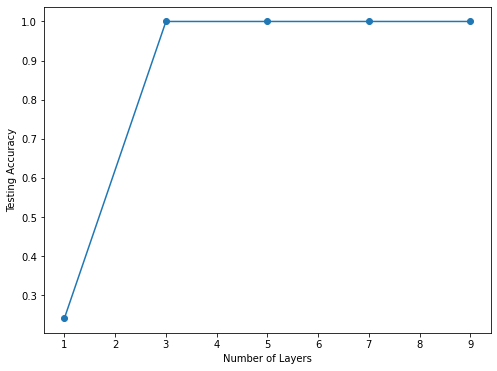

In [247]:
plt.figure(figsize=(8,6))
x = [i for i in range(1, 10, 2)]
plt.plot(x, acc_test_amp, '-o')
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")
plt.show()

From the plot above, we can see that with amplitude encoding and the current variational ansatz, 3 layers is already enough to reach the best performance.

#### 2. Angle Encoding

Let us now try to encode the 4 features into rotation angles (e.g. RY gates) of 4 qubits.

In [290]:
def AngEnc_Classifier(train_sets, train_labels, num_layers, test_sets=None, test_labels=None):
    """
    Train the classifier model based on angle embedding (RY) and computes the accuracy of the predictions based on the testing data.

    Args:
        - train_sets (np.ndarray): features of the training datasets
        - train_labels (np.ndarray): labels (categories) of the training datasets
        - num_layers (int): number of layers of the variational ansatz
        - test_sets (np.ndarray): features of the testing datasets
        - test_labels (np.ndarray): labels (categories) of the testing datasets

    Returns:
        - acc_test (float): accuracy of the predictions based on the testing datasets
    """

    dev = qml.device("lightning.qubit", wires=4)

    # def layer(W):
    #     # Start with a simple layer with RX, RY, RZ, and CNOT gates
    #     for i in range(4):
    #         qml.RX(W[i,0], wires=i)
    #         qml.RY(W[i,1], wires=i)
    #         qml.RZ(W[i,2], wires=i)
    #     qml.CNOT(wires=[0,1])
    #     qml.CNOT(wires=[1,2])
    #     qml.CNOT(wires=[2,3])
    #     qml.CNOT(wires=[3,1])

    @qml.qnode(dev)
    def circuit(weights, x):
        qml.AngleEmbedding(x, wires=range(4), rotation='Y')
        # Use Pennylane's StronglyEntanglingLayers as layers
        qml.templates.layers.StronglyEntanglingLayers(weights, wires=range(4))
        return qml.expval(qml.PauliZ(0))

    def var_classifier(weights, bias, x):
        return circuit(weights, x) + bias
    
    def cost(weights, bias, X, Y):
        predictions = [var_classifier(weights, bias, x) for x in X]
        return square_loss(predictions, Y)

    # Set up the training procedure
    data_size = len(train_sets)
    train_size = int(0.75*data_size)
    index = np.random.permutation(range(data_size))
    X_train = train_sets[index[:train_size]]
    Y_train = train_labels[index[:train_size]]
    X_val = train_sets[index[train_size:]]
    Y_val = train_labels[index[train_size:]]

    init_weights = np.random.uniform(low=0, high=2*np.pi, size=(num_layers, 4, 3), requires_grad=True)
    init_bias = np.array(0.0, requires_grad=True)
    opt = qml.optimize.AdamOptimizer(0.05)
    batch_size = 5
    max_iters = 100

    weights = init_weights
    bias = init_bias

    for i in range(max_iters+1):
        batch_index = np.random.randint(0, train_size, (batch_size,))
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

        predictions_train = [np.sign(var_classifier(weights, bias, x)) for x in X_train]
        predictions_val = [np.sign(var_classifier(weights, bias, x)) for x in X_val]

        # Compare accuracy on train and validation sets
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)

        if test_sets is None and test_labels is None:
            if i%10 == 0:
                print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(i, cost(weights, bias, train_sets, train_labels), acc_train, acc_val)
                )

    if test_sets is None and test_labels is None:
        pass 
    else:
        predictions_test = [np.sign(var_classifier(weights, bias, x)) for x in test_sets]
        acc_test = accuracy(test_labels, predictions_test)
        return acc_test

In [292]:
AngEnc_Classifier(X_train, Y_train, 3)

Iter:     0 | Cost: 1.2009955 | Acc train: 0.1955556 | Acc validation: 0.2000000 
Iter:    10 | Cost: 0.9351794 | Acc train: 0.6622222 | Acc validation: 0.6800000 
Iter:    20 | Cost: 0.8301140 | Acc train: 0.8177778 | Acc validation: 0.8266667 
Iter:    30 | Cost: 0.7124695 | Acc train: 0.8222222 | Acc validation: 0.8400000 
Iter:    40 | Cost: 0.7587405 | Acc train: 0.7333333 | Acc validation: 0.6133333 
Iter:    50 | Cost: 0.6663283 | Acc train: 0.8266667 | Acc validation: 0.8400000 
Iter:    60 | Cost: 0.6201278 | Acc train: 0.8222222 | Acc validation: 0.8400000 
Iter:    70 | Cost: 0.5890056 | Acc train: 0.8133333 | Acc validation: 0.8266667 
Iter:    80 | Cost: 0.5728518 | Acc train: 0.8177778 | Acc validation: 0.8400000 
Iter:    90 | Cost: 0.5589555 | Acc train: 0.8177778 | Acc validation: 0.8400000 
Iter:   100 | Cost: 0.5590651 | Acc train: 0.8177778 | Acc validation: 0.8400000 


In [293]:
acc_test_ang = []
for num_layers in range(1, 8):
    acc_test = AngEnc_Classifier(X_train, Y_train, num_layers, X_test, Y_test)
    print(acc_test)
    acc_test_ang.append(acc_test)

print(acc_test_ang)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


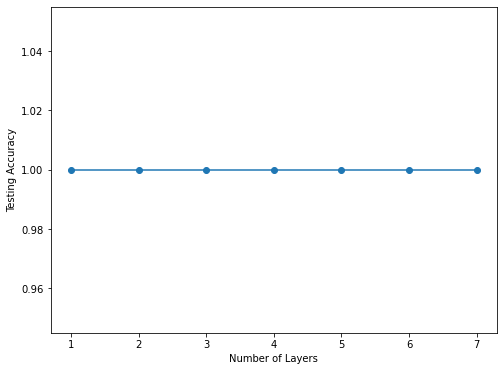

In [295]:
plt.figure(figsize=(8,6))
x = [i for i in range(1, 8)]
plt.plot(x, acc_test_ang, '-o')
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")
plt.show()

Comparing to amplitude embedding, we achieved perfect accuracy of the testing datasets with just one layer using angle embedding. However, it should be noted that angle embedding uses N qubits for N features, instead of log_2(N) for amplitude embedding, and therefore, the number of parameters in the variational ansatz is also larger. This might be one of the reasons why the number of layers needed to reach the best performance is less for angle embedding compared to amplitude embedding, given the same number of training steps.

#### 3. Instantaneous Quantum Polynomial (IQP) Encoding 

In [301]:
def IQPEnc_Classifier(train_sets, train_labels, num_layers, test_sets=None, test_labels=None):
    """
    Train the classifier model based on IQP encoding and computes the accuracy of the predictions based on the testing data.

    Args:
        - train_sets (np.ndarray): features of the training datasets
        - train_labels (np.ndarray): labels (categories) of the training datasets
        - num_layers (int): number of layers of the variational ansatz
        - test_sets (np.ndarray): features of the testing datasets
        - test_labels (np.ndarray): labels (categories) of the testing datasets

    Returns:
        - acc_test (float): accuracy of the predictions based on the testing datasets
    """

    dev = qml.device("lightning.qubit", wires=4)

    # Manual IQP encoding
    def state_prep(x):
        S = [[0,1],[1,2],[2,3]]
        for i in range(4):
            qml.Hadamard(wires=i)
        for j in range(4):
            qml.RZ(x[j], wires=j)
        for k in S:
            qml.CNOT(wires=k)
            qml.RZ(x[k[0]]*x[k[1]], wires=k[1])
            qml.CNOT(wires=k)

    @qml.qnode(dev)
    def circuit(weights, x):
        # qml.IQPEmbedding(x, wires=range(4))
        state_prep(x)
        # Use Pennylane's StronglyEntanglingLayers as layers
        qml.templates.layers.StronglyEntanglingLayers(weights, wires=range(4))
        return qml.expval(qml.PauliZ(0))

    def var_classifier(weights, bias, x):
        return circuit(weights, x) + bias
    
    def cost(weights, bias, X, Y):
        predictions = [var_classifier(weights, bias, x) for x in X]
        return square_loss(predictions, Y)

    # Set up the training procedure
    data_size = len(train_sets)
    train_size = int(0.75*data_size)
    index = np.random.permutation(range(data_size))
    X_train = train_sets[index[:train_size]]
    Y_train = train_labels[index[:train_size]]
    X_val = train_sets[index[train_size:]]
    Y_val = train_labels[index[train_size:]]

    init_weights = np.random.uniform(low=0, high=2*np.pi, size=(num_layers, 4, 3), requires_grad=True)
    init_bias = np.array(0.0, requires_grad=True)
    opt = qml.optimize.AdamOptimizer(0.05)
    batch_size = 5
    max_iters = 100

    weights = init_weights
    bias = init_bias

    for i in range(max_iters+1):
        batch_index = np.random.randint(0, train_size, (batch_size,))
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

        predictions_train = [np.sign(var_classifier(weights, bias, x)) for x in X_train]
        predictions_val = [np.sign(var_classifier(weights, bias, x)) for x in X_val]

        # Compare accuracy on train and validation sets
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)

        if test_sets is None and test_labels is None:
            if i%10 == 0:
                print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(i, cost(weights, bias, train_sets, train_labels), acc_train, acc_val)
                )

    if test_sets is None and test_labels is None:
        pass 
    else:
        predictions_test = [np.sign(var_classifier(weights, bias, x)) for x in test_sets]
        acc_test = accuracy(test_labels, predictions_test)
        return acc_test

In [302]:
IQPEnc_Classifier(X_train, Y_train, 3)

Iter:     0 | Cost: 1.0748265 | Acc train: 0.5066667 | Acc validation: 0.3866667 
Iter:    10 | Cost: 0.8370541 | Acc train: 0.7377778 | Acc validation: 0.8000000 
Iter:    20 | Cost: 0.7175417 | Acc train: 0.8533333 | Acc validation: 0.8133333 
Iter:    30 | Cost: 0.6302830 | Acc train: 0.8577778 | Acc validation: 0.7466667 
Iter:    40 | Cost: 0.5874194 | Acc train: 0.8577778 | Acc validation: 0.7600000 
Iter:    50 | Cost: 0.5639551 | Acc train: 0.8577778 | Acc validation: 0.7466667 
Iter:    60 | Cost: 0.5504067 | Acc train: 0.8622222 | Acc validation: 0.7600000 
Iter:    70 | Cost: 0.5400986 | Acc train: 0.8666667 | Acc validation: 0.7600000 
Iter:    80 | Cost: 0.5397065 | Acc train: 0.8622222 | Acc validation: 0.7600000 
Iter:    90 | Cost: 0.5419439 | Acc train: 0.8622222 | Acc validation: 0.7600000 
Iter:   100 | Cost: 0.5834891 | Acc train: 0.8266667 | Acc validation: 0.7733333 


In [303]:
acc_test_IQP = []
for num_layers in range(1, 6):
    acc_test = IQPEnc_Classifier(X_train, Y_train, num_layers, X_test, Y_test)
    print(acc_test)
    acc_test_IQP.append(acc_test)

print(acc_test_IQP)

0.9083333333333333
1.0
1.0
1.0
1.0
[0.9083333333333333, 1.0, 1.0, 1.0, 1.0]


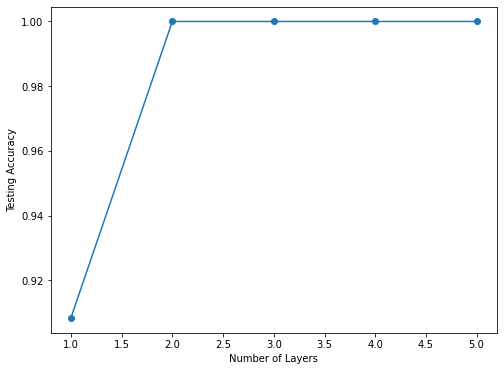

In [305]:
plt.figure(figsize=(8,6))
x = [i for i in range(1, 6)]
plt.plot(x, acc_test_IQP, '-o')
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")
plt.show()

The performance with IQP encoding is similar to that of angle encoding, as IQP is a special form of angle encoding itself. But it is believed to make the encoding "richer" through interference, especially for larger feature sets.